In [31]:
import torch
import torchvision  # type: ignore
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
batch_size_train = 128
batch_size_test = 1000

In [8]:
train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                   ])), batch_size=batch_size_train, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                   ])), batch_size=batch_size_test, shuffle=True
    )

In [39]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 4*4*50)
        x = self.classifier(x)
        return x


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 25),
            nn.ReLU(),
            nn.Linear(25, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flc_block(x)

        return x


In [35]:
def train(device, model, train_loader, learning_rate=0.0001, epochs=5, model_save_path='best_model.pth'):
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)

            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        average_loss = epoch_loss / len(train_loader)
        history.append(average_loss)

        if average_loss < best_loss:
            best_loss = average_loss
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved with loss {best_loss} at epoch {epoch + 1}')

        print(f'Epoch {epoch + 1}, Loss: {average_loss}')

    plt.plot(range(0, epochs), history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.show()

In [12]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy:.2%}")

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

  5%|▌         | 1/20 [00:14<04:39, 14.72s/it]

Model saved with loss 0.5646600772831232 at epoch 1
Epoch 1, Loss: 0.5646600772831232


 10%|█         | 2/20 [00:29<04:22, 14.56s/it]

Model saved with loss 0.16038935792757503 at epoch 2
Epoch 2, Loss: 0.16038935792757503


 15%|█▌        | 3/20 [00:43<04:03, 14.34s/it]

Model saved with loss 0.10812889483930078 at epoch 3
Epoch 3, Loss: 0.10812889483930078


 20%|██        | 4/20 [00:57<03:47, 14.24s/it]

Model saved with loss 0.08672975169530492 at epoch 4
Epoch 4, Loss: 0.08672975169530492


 25%|██▌       | 5/20 [01:11<03:34, 14.30s/it]

Model saved with loss 0.07036197738253328 at epoch 5
Epoch 5, Loss: 0.07036197738253328


 30%|███       | 6/20 [01:27<03:28, 14.89s/it]

Model saved with loss 0.060683530878458326 at epoch 6
Epoch 6, Loss: 0.060683530878458326


 35%|███▌      | 7/20 [01:42<03:10, 14.69s/it]

Model saved with loss 0.05399513608023429 at epoch 7
Epoch 7, Loss: 0.05399513608023429


 40%|████      | 8/20 [01:56<02:54, 14.51s/it]

Model saved with loss 0.047646331253336435 at epoch 8
Epoch 8, Loss: 0.047646331253336435


 45%|████▌     | 9/20 [02:10<02:37, 14.36s/it]

Model saved with loss 0.04351900228019208 at epoch 9
Epoch 9, Loss: 0.04351900228019208


 50%|█████     | 10/20 [02:24<02:23, 14.37s/it]

Model saved with loss 0.039019724347694185 at epoch 10
Epoch 10, Loss: 0.039019724347694185


 55%|█████▌    | 11/20 [02:39<02:09, 14.38s/it]

Model saved with loss 0.036704751125264806 at epoch 11
Epoch 11, Loss: 0.036704751125264806


 60%|██████    | 12/20 [02:53<01:54, 14.29s/it]

Model saved with loss 0.03344949498387383 at epoch 12
Epoch 12, Loss: 0.03344949498387383


 65%|██████▌   | 13/20 [03:06<01:39, 14.17s/it]

Model saved with loss 0.03021808302125284 at epoch 13
Epoch 13, Loss: 0.03021808302125284


 70%|███████   | 14/20 [03:20<01:24, 14.11s/it]

Model saved with loss 0.02910334152032508 at epoch 14
Epoch 14, Loss: 0.02910334152032508


 75%|███████▌  | 15/20 [03:34<01:10, 14.06s/it]

Model saved with loss 0.02710949006561897 at epoch 15
Epoch 15, Loss: 0.02710949006561897


 80%|████████  | 16/20 [03:48<00:55, 13.98s/it]

Model saved with loss 0.025156511302624366 at epoch 16
Epoch 16, Loss: 0.025156511302624366


 85%|████████▌ | 17/20 [04:02<00:41, 13.99s/it]

Model saved with loss 0.023473570178171543 at epoch 17
Epoch 17, Loss: 0.023473570178171543


 90%|█████████ | 18/20 [04:16<00:27, 13.97s/it]

Model saved with loss 0.022410030743585767 at epoch 18
Epoch 18, Loss: 0.022410030743585767


 95%|█████████▌| 19/20 [04:30<00:13, 14.00s/it]

Model saved with loss 0.019753674290198555 at epoch 19
Epoch 19, Loss: 0.019753674290198555


100%|██████████| 20/20 [04:44<00:00, 14.24s/it]

Model saved with loss 0.01942852772000347 at epoch 20
Epoch 20, Loss: 0.01942852772000347


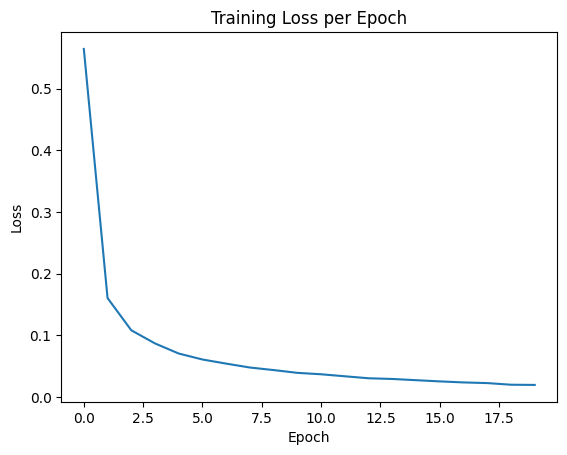

In [37]:
train(device, model, train_loader, epochs=20)

Accuracy on the test set: 99.28%


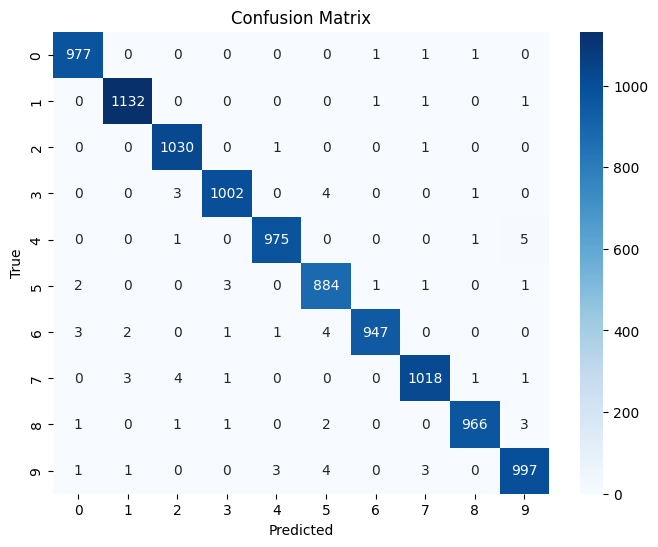

In [38]:
test(model, device, test_loader)

In [40]:
def validate(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        dataset = test_loader.dataset
        random_index = np.random.randint(0, len(dataset))
        single_example = dataset[random_index]
        images, labels = single_example[0], single_example[1]
        images = images.unsqueeze(0).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print(f"Предсказано: {predicted.item()}, Реально: {labels}")


In [41]:
dataset = test_loader.dataset
random_index = int(np.random.random()*len(dataset))
single_example = dataset[random_index]

In [42]:
validate(model, device, test_loader)

Предсказано: 0, Реально: 0
